### Import and data loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
import numpy as np

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import scipy
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2
from sklearn.model_selection import cross_val_predict, train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [3]:
#Import data
kilothonGames = pd.read_csv('KilothonGames.csv')
concepts = pd.read_csv('concepts.csv')
gamerules = pd.read_csv('gamerulesets.csv')
games = pd.read_csv('games.csv')
rulesetconcept = pd.read_csv('rulesetconcepts.csv')
rsc_uct = pd.read_csv('rulesetconceptsuct.csv')
rsc_ab = pd.read_csv('rulesetconceptsab.csv')

### Get infos of the different database

In [4]:
#Shapes

print(concepts.shape)
print(gamerules.shape)
print(games.shape)
print(rulesetconcept.shape)
print(rsc_uct.shape)
print(rsc_ab.shape)

(779, 9)
(1854, 20)
(1458, 26)
(1106316, 5)
(1164417, 5)
(1164417, 5)


In [5]:
# Column names for each df
print(concepts.columns)
print(gamerules.columns)
print(games.columns)
print(rulesetconcept.columns)
print(rsc_uct.columns)
print(rsc_ab.columns)

Index(['Unnamed: 0', 'Id', 'Name', 'Description', 'TypeId', 'DataTypeId',
       'ComputationTypeId', 'TaxonomyString', 'LeafNode'],
      dtype='object')
Index(['Unnamed: 0', 'Id', 'GameId', 'Name', 'NativeName', 'Summary', 'Type',
       'Description', 'Rules', 'Reference', 'Origin', 'Author', 'Publisher',
       'Date', 'OriginPoint', 'EvidenceRange', 'SelfContained', 'Notes',
       'DisableWebApp', 'WishlistRuleset'],
      dtype='object')
Index(['Unnamed: 0', 'Id', 'Name', 'NativeName', 'Description', 'MainRuleset',
       'LudiiRuleset', 'Reference', 'Origin', 'DLPGame', 'PublicGame',
       'knownAliases', 'Author', 'Publisher', 'ProprietaryGame', 'Credit',
       'SeeAlso', 'BGGId', 'OriginPoint', 'EvidenceRange', 'WishlistGame',
       'Notes', 'HelpUs', 'ForceRulesetInLud', 'DisableWebApp',
       'ReconstructionDescriptionDone'],
      dtype='object')
Index(['Unnamed: 0', 'Id', 'RulesetId', 'ConceptId', 'Value'], dtype='object')
Index(['Unnamed: 0', 'Id', 'RulesetId', 'Conc

As discussed, we will only keep the following columns for our final datframe:

- Concepts: ID, LeafNode
- Gamerules: ID, GameID, Name, Type
- Games: ID, Name, MainRuleSet, LudiiRuleset
- Rulesetconcept: ID, RuleSetId, ConceptID, value 

In [6]:
concepts = concepts[~concepts['TaxonomyString'].str.startswith('6')]
concepts = concepts[concepts['LeafNode']!=0]

In [7]:
concepts = concepts.drop([ 'Unnamed: 0', 'Description', 'TypeId', 'DataTypeId', 'ComputationTypeId', 'TaxonomyString'], axis = 1);
gamerules = gamerules.drop(['Unnamed: 0', 'NativeName', 'Summary', 'Description', 'Rules', 'Reference', 'Origin', 'Author', 'Publisher', 'Date', 'OriginPoint', 'EvidenceRange', 'SelfContained', 'Notes', 'DisableWebApp', 'WishlistRuleset', 'Type'], axis = 1);
games = games.drop(['Unnamed: 0','NativeName', 'Description', 'Reference', 'Origin', 'DLPGame', 'PublicGame', 'knownAliases', 'Author', 'Publisher', 'ProprietaryGame', 'Credit', 'SeeAlso', 'BGGId', 'OriginPoint', 'EvidenceRange', 'WishlistGame', 'Notes', 'HelpUs', 'ForceRulesetInLud', 'DisableWebApp', 'ReconstructionDescriptionDone'], axis = 1);
rulesetconcept = rulesetconcept.drop(['Unnamed: 0'], axis = 1)
rsc_uct = rsc_uct.drop(['Unnamed: 0'], axis = 1)
rsc_ab = rsc_ab.drop(['Unnamed: 0'], axis = 1)
concepts

,Id,Name,LeafNode
3,4,Discrete,1
4,5,Realtime,1
6,7,Alternating,1
7,8,Simultaneous,1
8,9,Stochastic,1
...,...,...,...
774,775,DoLudeme,1
775,776,Trigger,1
776,777,PlayoutsPerSecond,1
777,778,MovesPerSecond,1


Now that the df are filtered with the only attributes that we need, we will merge them in a final dataframe.

We will join using the following idea: 

Join Game Ruleset and Games on GameId and Id  --> Merge_One

Join Game Ruleset and Ruleset Concepts on Id and RulesetId --> Merge_two		

Join Concepts and Ruleset Concepts on Id and ConceptId --> Merge_three

In [8]:
def merge(one, two, on, left, right):
  new = pd.merge(one, two, on = on, left_on = left, right_on = right)

  return new

In [9]:
merge_one = merge(games, gamerules, None, 'Id', 'GameId')
merge_two = merge(rulesetconcept, gamerules, None, 'RulesetId', 'Id')
merge_three = merge(concepts, rulesetconcept, None, 'Id', 'ConceptId')

merge_three.drop(['Id_y'], axis=1, inplace=True)
merge_three = merge_three[merge_three['LeafNode']!=0]

Create a dataframe by merging the first three created above

In [10]:
df = merge(merge_one, merge_two, 'GameId', None, None)
df = df.drop([ 'Id_y_y', 'Id_x_x', 'Value', 'Id_x_y', 'ConceptId', 'Name_y', 'Id_y_x'], axis = 1);
df.head()

,Name_x,MainRuleset,LudiiRuleset,GameId,RulesetId,Name
0,Senet,528,529.0,3,529,Bell
1,Senet,528,529.0,3,529,Bell
2,Senet,528,529.0,3,529,Bell
3,Senet,528,529.0,3,529,Bell
4,Senet,528,529.0,3,529,Bell


Do the same merging as merge 3 but for the datasets of UCT and AB

In [11]:
merge_three_uct = pd.merge(concepts, rsc_uct, left_on='Id', right_on='ConceptId')

merge_three_uct.drop(['Id_y'], axis=1, inplace=True)
merge_three_uct = merge_three_uct[merge_three_uct['LeafNode']!=0]
merge_three_uct.head()

,Id_x,Name,LeafNode,RulesetId,ConceptId,Value
0,4,Discrete,1,1656,4,1.0
1,4,Discrete,1,1979,4,1.0
2,4,Discrete,1,35,4,1.0
3,4,Discrete,1,1391,4,1.0
4,4,Discrete,1,1796,4,1.0


In [12]:
merge_three_ab = pd.merge(concepts, rsc_ab, left_on='Id', right_on='ConceptId')

merge_three_ab.drop(['Id_y'], axis=1, inplace=True)
merge_three_ab = merge_three_ab[merge_three_ab['LeafNode']!=0]
merge_three_ab.head()

,Id_x,Name,LeafNode,RulesetId,ConceptId,Value
0,4,Discrete,1,1656,4,1.0
1,4,Discrete,1,1979,4,1.0
2,4,Discrete,1,35,4,1.0
3,4,Discrete,1,1391,4,1.0
4,4,Discrete,1,1796,4,1.0


In [13]:
def new_merge(merge_three):
  one = merge_three.groupby('RulesetId')['Name'].apply(list)
  one = one.to_frame()
  two = pd.merge(one, merge_three, on = 'RulesetId')

  three = two.groupby('RulesetId')['Value'].apply(list)
  three = three.to_frame()

  final = pd.merge(two, three, on = 'RulesetId')

  final.drop(['Name_y', 'LeafNode', 'ConceptId', 'Value_x', 'Id_x'], axis=1, inplace = True)
  final.drop_duplicates(subset = ['RulesetId'], inplace = True)
  return final

In [14]:
new_merge_ = new_merge(merge_three)

In [15]:
new_merge_uct = new_merge(merge_three_uct)

In [16]:
new_merge_ab = new_merge(merge_three_ab)

In [17]:
df = pd.merge(df, new_merge_, on = 'RulesetId')
df.rename(columns = {'Name_x_x' : 'Game', 'Name_x_y' : 'Concepts', 'Value_y' : 'Concepts_values'}, inplace = True)
df = pd.merge(df, new_merge_ab, on='RulesetId')
df.rename(columns = {'Name_x' : 'Concepts_AB', 'Value_y' : 'Concepts_values_AB'}, inplace = True)
df = pd.merge(df, new_merge_uct, on='RulesetId')
df.drop_duplicates(subset = ['RulesetId'], inplace = True)
df.rename(columns = {'Name_x' : 'Concepts_UCT', 'Value_y' : 'Concepts_values_UCT'}, inplace = True)
df.head()

,Game,MainRuleset,LudiiRuleset,GameId,RulesetId,Name,Concepts,Concepts_values,Concepts_AB,Concepts_values_AB,Concepts_UCT,Concepts_values_UCT
0,Senet,528,529.0,3,529,Bell,"[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
21784,Senet,528,529.0,3,939,Jequier,"[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
43568,Senet,528,529.0,3,922,Kendall,"[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
65352,Senet,528,529.0,3,937,Kendall All Options,"[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
87136,Senet,528,529.0,3,923,Kendall Five Pieces,"[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


In [18]:
c_ab = df.iloc[0]['Concepts_AB']
for i in range(len(c_ab)):
  c_ab[i] = c_ab[i] + '_AB'

c_uct = df.iloc[0]['Concepts_UCT']
for i in range(len(c_uct)):
  c_uct[i] = c_uct[i] + '_UCT'

In [19]:
df[c_ab] = pd.DataFrame(df.Concepts_values_AB.tolist(), index= df.index)

df.drop(['Concepts_AB', 'Concepts_values_AB'], axis=1, inplace = True)
df.head()

,Game,MainRuleset,LudiiRuleset,GameId,RulesetId,Name,Concepts,Concepts_values,Concepts_UCT,Concepts_values_UCT,...,SetHiddenWhat_AB,SetHiddenWho_AB,CopyContext_AB,Then_AB,ForEachPiece_AB,DoLudeme_AB,Trigger_AB,PlayoutsPerSecond_AB,MovesPerSecond_AB,OutcomeUniformity_AB
0,Senet,528,529.0,3,529,Bell,"[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[Discrete_UCT, Realtime_UCT, Alternating_UCT, ...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1358.93,166173.49,NaN
21784,Senet,528,529.0,3,939,Jequier,"[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,155.01,107657.20,NaN
43568,Senet,528,529.0,3,922,Kendall,"[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,318.51,81394.19,NaN
65352,Senet,528,529.0,3,937,Kendall All Options,"[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,321.79,81613.66,NaN
87136,Senet,528,529.0,3,923,Kendall Five Pieces,"[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,445.57,84795.32,NaN


In [20]:
df[c_uct] = pd.DataFrame(df.Concepts_values_UCT.tolist(), index= df.index)

df.drop(['Concepts_UCT', 'Concepts_values_UCT'], axis=1, inplace = True)
df.head()

,Game,MainRuleset,LudiiRuleset,GameId,RulesetId,Name,Concepts,Concepts_values,Discrete_AB,Realtime_AB,...,SetHiddenWhat_UCT,SetHiddenWho_UCT,CopyContext_UCT,Then_UCT,ForEachPiece_UCT,DoLudeme_UCT,Trigger_UCT,PlayoutsPerSecond_UCT,MovesPerSecond_UCT,OutcomeUniformity_UCT
0,Senet,528,529.0,3,529,Bell,"[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1246.27,152434.05,NaN
21784,Senet,528,529.0,3,939,Jequier,"[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,126.63,90267.74,NaN
43568,Senet,528,529.0,3,922,Kendall,"[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,259.06,65906.43,NaN
65352,Senet,528,529.0,3,937,Kendall All Options,"[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,273.09,66913.65,NaN
87136,Senet,528,529.0,3,923,Kendall Five Pieces,"[Discrete, Realtime, Alternating, Simultaneous...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,396.11,75353.50,NaN


In [21]:
c=df['Concepts'].explode().unique()
df[c] = pd.DataFrame(df.Concepts_values.tolist(), index= df.index)

df.drop(['Concepts', 'Concepts_values'], axis=1, inplace = True)
df.head()

,Game,MainRuleset,LudiiRuleset,GameId,RulesetId,Name,Discrete_AB,Realtime_AB,Alternating_AB,Simultaneous_AB,...,SetHiddenValue,SetHiddenWhat,SetHiddenWho,CopyContext,Then,ForEachPiece,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond
0,Senet,528,529.0,3,529,Bell,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1266.24,154613.78
21784,Senet,528,529.0,3,939,Jequier,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,337.43,87643.94
43568,Senet,528,529.0,3,922,Kendall,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,292.51,72076.99
65352,Senet,528,529.0,3,937,Kendall All Options,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,343.81,74169.23
87136,Senet,528,529.0,3,923,Kendall Five Pieces,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,445.21,84469.25


In [22]:
kilothonGames['RulesetId'] = kilothonGames['RulesetId'].astype('int')
df = pd.merge(df, kilothonGames, on = 'RulesetId')

In [23]:
df.shape

(1104, 1521)

In [24]:
df = df.T.drop_duplicates().T
# df = df.drop_duplicates()

In [25]:
df.head()

,Game,MainRuleset,LudiiRuleset,GameId,RulesetId,Name,Discrete_AB,Realtime_AB,Stochastic_AB,AsymmetricPiecesType_AB,...,Union,Intersection,Complement,ConditionalStatement,ControlFlowStatement,CopyContext,DoLudeme,PlayoutsPerSecond,MovesPerSecond,Name
0,Senet,528,529,3,922,Kendall,1,0,1,0,...,1,1,1,1,1,1,1,292.51,72077,Senet
1,Ludus Latrunculorum,32,534,4,534,Schadler 1994,1,0,0,0,...,1,0,0,1,1,0,0,181.25,45676,Ludus Latrunculorum
2,XII Scripta,533,33,5,33,Murray,1,0,1,0,...,1,0,0,1,1,1,1,201.52,51387.4,XII Scripta
3,Mehen,34,542,6,542,Kendall,1,0,1,0,...,1,0,0,1,1,1,1,413.62,105886,Mehen
4,20 Squares,530,35,7,35,Seleucid,1,0,1,0,...,1,0,0,1,1,1,1,1050.14,135749,20 Squares


In [26]:
df.shape

(1104, 669)

In [27]:
df.to_csv('data.csv')

# Feature Selection

## Part 1: PCA

In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [29]:
data = df.copy()
data.drop(['Name', 'Game', ' Name'], axis = 1, inplace = True);

In [30]:
data.fillna(-1, inplace = True)
X = pd.DataFrame(scale(data), index=data.index, columns=data.columns)

In [31]:
def get_variance(X, n):
  scaler = StandardScaler()
  pca = PCA(n_components=n)

  pca.fit(scaler.fit_transform(X))
  return pca.explained_variance_ratio_.cumsum()[-1:]

In [32]:
for i in range(1,150):
  print('Components:\t', i, '=\t', get_variance(X, i), '\tCumulative Variance')

Components:	 1 =	 [0.06402362] 	Cumulative Variance
Components:	 2 =	 [0.11173509] 	Cumulative Variance
Components:	 3 =	 [0.15218252] 	Cumulative Variance
Components:	 4 =	 [0.19033258] 	Cumulative Variance
Components:	 5 =	 [0.21529276] 	Cumulative Variance
Components:	 6 =	 [0.23782348] 	Cumulative Variance
Components:	 7 =	 [0.25893989] 	Cumulative Variance
Components:	 8 =	 [0.27794997] 	Cumulative Variance
Components:	 9 =	 [0.293617] 	Cumulative Variance
Components:	 10 =	 [0.30861315] 	Cumulative Variance
Components:	 11 =	 [0.32256067] 	Cumulative Variance
Components:	 12 =	 [0.3358826] 	Cumulative Variance
Components:	 13 =	 [0.34846103] 	Cumulative Variance
Components:	 14 =	 [0.36092228] 	Cumulative Variance
Components:	 15 =	 [0.37274373] 	Cumulative Variance
Components:	 16 =	 [0.38429047] 	Cumulative Variance
Components:	 17 =	 [0.3952109] 	Cumulative Variance
Components:	 18 =	 [0.40608947] 	Cumulative Variance
Components:	 19 =	 [0.41635941] 	Cumulative Variance
Compon

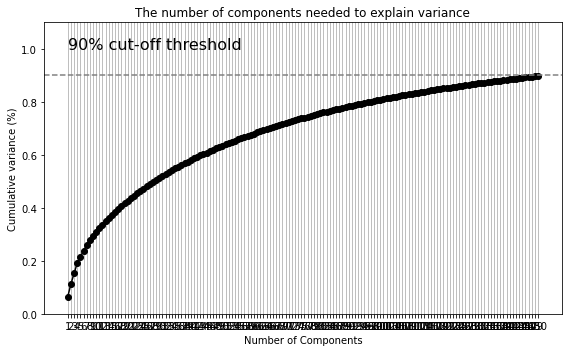

In [33]:
scaler = StandardScaler()
data_rescaled = scaler.fit_transform(X)

pca = PCA().fit(data_rescaled)

plt.rcParams["figure.figsize"] = (8,5)

fig, ax = plt.subplots()
xi = np.arange(1, 151, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi[:150], y[:150], marker='o', linestyle='-', color='black')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 151, step=1)) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.90, color='grey', linestyle='--')
plt.text(1.1, 1, '90% cut-off threshold', color = 'black', fontsize=16)

ax.grid(axis='x')
plt.tight_layout()
plt.savefig('pcavisualize_1.png', dpi=300)

In [59]:
pca = PCA(n_components=150)
pca = pca.fit(X)
X_pca = pca.transform(X)
components = pca.components_.T
X = np.array(X)
X_pca_test = np.matmul(X, components)
X_pca_test = np.around(X_pca_test, decimals=3)
X_pca = np.around(X_pca, decimals=3)
np.array_equal(X_pca,X_pca_test)

True

In [61]:
pd.DataFrame(components).to_csv('components.csv')

## Part 2: Feature Selection

In [35]:
from lightgbm import LGBMRegressor
from joblib import Parallel, delayed
import seaborn as sns
from matplotlib.pyplot import figure

In [36]:
class FeatureSelector:
  def __init__(self, k=0.5):
    self.regressor = LGBMRegressor()
    self.k = k
    
  def calc_feature_importance(self, index, X):
    ft_imp = np.zeros(X.shape[1])
    x_train = np.concatenate((X[:,:index], X[:,index+1:]), axis=1)
    y_train = X[:,index]
    self.regressor.fit(x_train, y_train)
    i = np.concatenate((np.reshape(np.arange(index), (-1,1)), np.reshape(np.arange(index+1, X.shape[1]), (-1, 1))), axis=0)[:,0]
    try:
        ft_imp[i]+= self.regressor.feature_importances_
    except:
        ft_imp[i]+= self.regressor.coef_
    return ft_imp

  def fit(self, X):
    self.cols = X.columns
    X = X.values
    parallel = Parallel(n_jobs=-1, verbose=0)
    ft_imps = parallel(delayed(self.calc_feature_importance)(i, X) for i in range(X.shape[1]))
    self.ft_imps = np.average(np.asarray(ft_imps), axis=0)
    i = np.argsort(np.absolute(self.ft_imps))[::-1]
    self.cols = self.cols[i]
    self.ft_imps = self.ft_imps[i]
    self.k = round(self.k * X.shape[1])

  def disp_ft_imp(self):
    y_axis = np.arange(len(self.cols))
    x_axis = self.ft_imps

    sns.lineplot(x=x_axis, y=[self.k for i in range(len(y_axis))], linestyle='--')
    sns.barplot(x=x_axis, y=y_axis, orient="h")
    plt.yticks(y_axis, self.cols, size='small')

    plt.xlabel("Importance Scores")
    plt.ylabel("Features")
    sns.despine()
    plt.savefig('feature_importance.png', dpi=300)
    plt.show()

In [37]:
model = FeatureSelector()
model.fit(pd.DataFrame(X_pca))

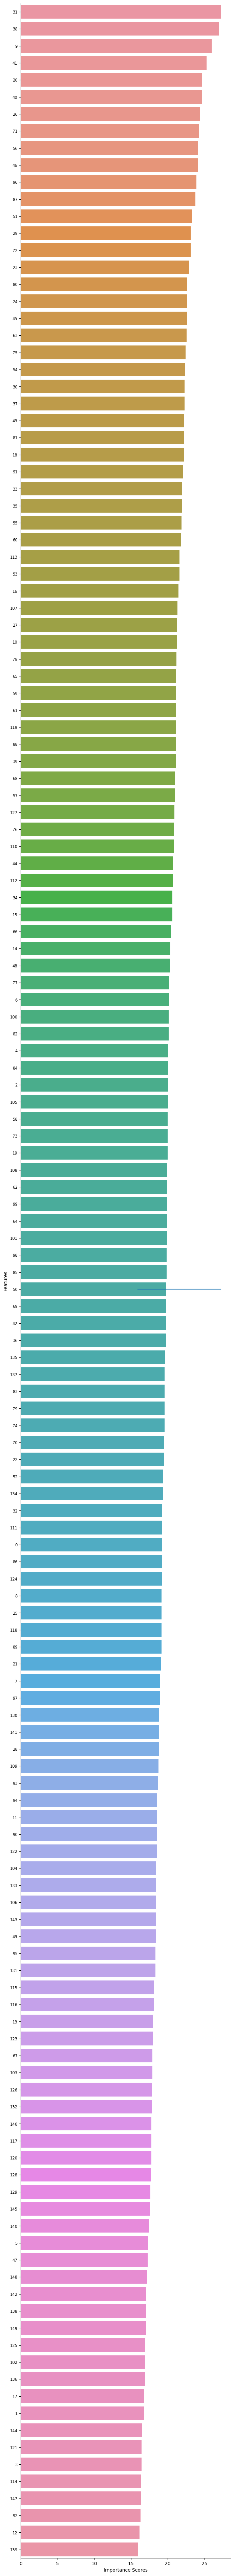

In [38]:
figure(figsize=(8, 100), dpi=100)
model.disp_ft_imp()

In [39]:
features = pd.DataFrame(model.cols).head(model.k)
features = features.iloc[:, 0]
np.array(features)
X_pca_sel = pd.DataFrame(X_pca)[features]
X_pca_sel.head()

,31,38,9,41,20,40,26,71,56,46,...,58,73,19,108,62,99,64,101,98,85
0,-1.495,0.073,-2.010,4.408,-0.237,1.408,-5.255,5.395,5.055,22.246,...,-3.562,1.907,-3.969,0.253,13.218,-0.661,0.584,0.332,1.454,2.841
1,0.366,1.220,-3.038,-1.170,-0.723,-2.641,-2.783,-0.597,0.137,-0.853,...,1.318,-0.922,-1.076,-4.515,0.362,-0.096,0.385,-1.400,-0.531,-0.285
2,-0.093,0.055,-2.739,-0.778,-0.331,-0.073,0.871,-0.446,-0.421,-0.359,...,0.512,-0.712,1.622,-0.295,0.208,-0.281,-0.546,-0.762,-0.276,0.393
3,3.010,-4.473,2.898,0.057,1.716,-7.765,7.720,1.316,-4.759,-5.076,...,1.648,2.695,2.902,-1.499,2.016,-0.487,-0.772,-1.100,1.142,-0.110
4,0.296,1.049,-0.881,1.635,-0.359,-0.979,-0.250,-1.657,-0.931,2.076,...,0.482,-1.743,4.198,0.993,-0.169,-0.140,2.215,0.359,-0.576,-0.543


## Part 3: Clustering

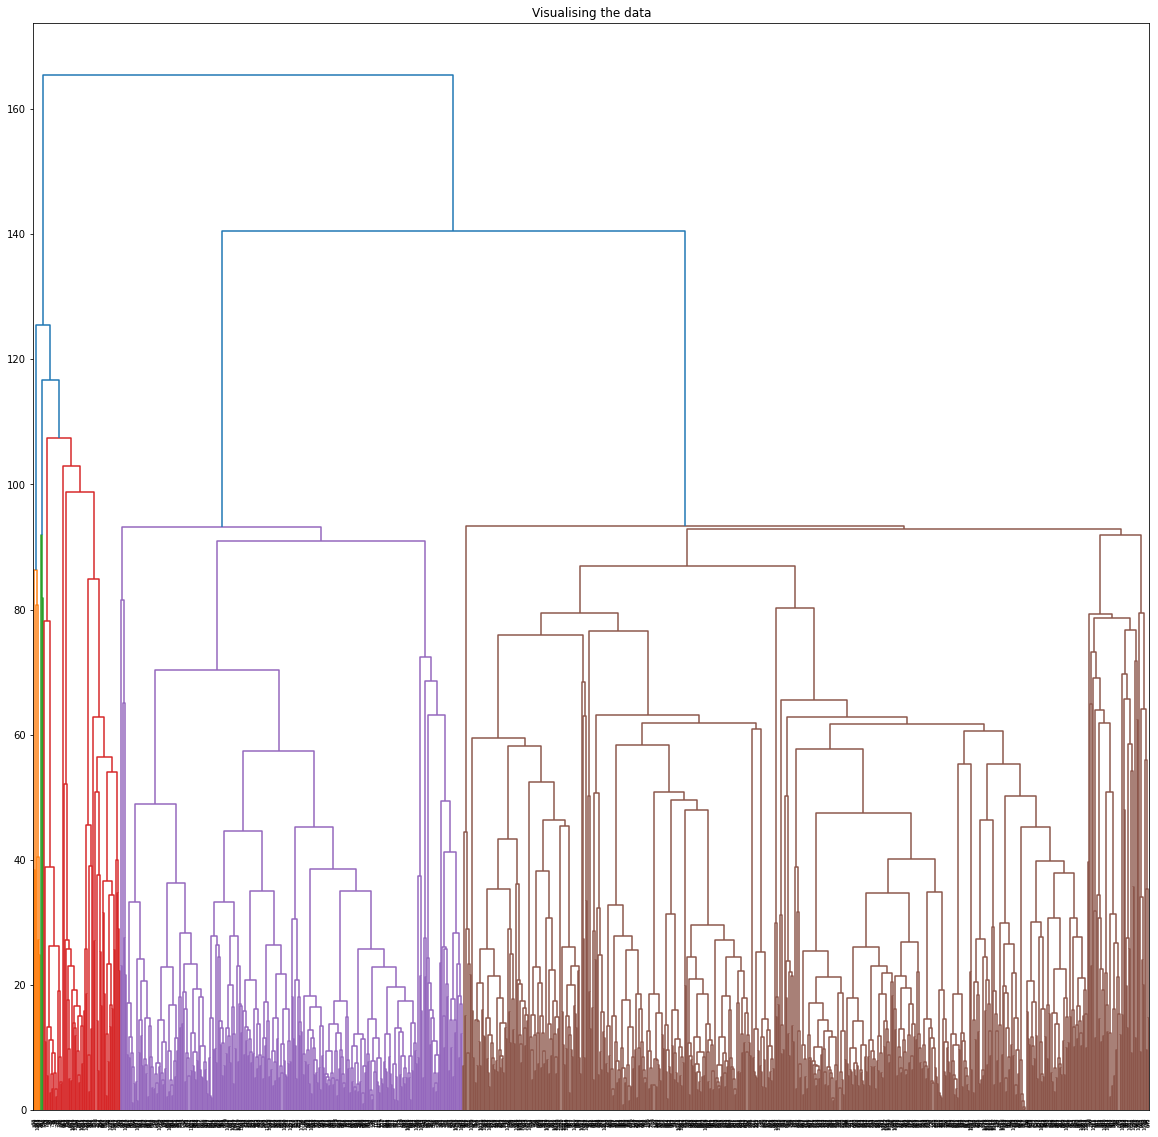

In [40]:
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
plt.figure(figsize =(20, 20))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X_pca_sel, method ='ward')))

In [41]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

n_clusters = 5
clustering = AgglomerativeClustering(n_clusters).fit(X_pca_sel)
clustering

clustering.labels_

array([1, 2, 1, ..., 2, 1, 2], dtype=int64)

In [42]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_pca_sel)
prediction = kmeans.predict(X_pca_sel)
prediction

array([3, 3, 3, ..., 3, 3, 3])

In [47]:
df

,Game,MainRuleset,LudiiRuleset,GameId,RulesetId,Name,Discrete_AB,Realtime_AB,Stochastic_AB,AsymmetricPiecesType_AB,...,Union,Intersection,Complement,ConditionalStatement,ControlFlowStatement,CopyContext,DoLudeme,PlayoutsPerSecond,MovesPerSecond,Name
0,Senet,528,529,3,922,Kendall,1,0,1,0,...,1,1,1,1,1,1,1,292.51,72077,Senet
1,Ludus Latrunculorum,32,534,4,534,Schadler 1994,1,0,0,0,...,1,0,0,1,1,0,0,181.25,45676,Ludus Latrunculorum
2,XII Scripta,533,33,5,33,Murray,1,0,1,0,...,1,0,0,1,1,1,1,201.52,51387.4,XII Scripta
3,Mehen,34,542,6,542,Kendall,1,0,1,0,...,1,0,0,1,1,1,1,413.62,105886,Mehen
4,20 Squares,530,35,7,35,Seleucid,1,0,1,0,...,1,0,0,1,1,1,1,1050.14,135749,20 Squares
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,Dama (Kenya),1989,1989,1592,1989,Dama (Kenya),1,0,0,0,...,1,0,0,1,1,1,0,561.89,59328.9,Dama (Kenya)
1100,Dama (Comoros),1990,1990,1593,1990,Dama (Comoros),1,0,0,0,...,1,0,0,1,1,0,0,317.5,86802.1,Dama (Comoros)
1101,Mraha wa Bwe,1991,1991,1594,1991,Mraha wa Bwe,1,0,0,0,...,1,0,1,1,1,0,0,1048.57,212598,Mraha wa Bwe
1102,Dama (Alquerque),1992,1992,1595,1992,Dama (Alquerque),1,0,0,0,...,1,0,0,1,1,1,1,564.86,75956.9,Dama (Alquerque)


In [53]:
prediction = pd.DataFrame(prediction)
data_labelled = prediction.join(df)
data_labelled = data_labelled.iloc[:, [0, 1]]
data_labelled.columns = ['Cluster', 'Name']
data_labelled

,Cluster,Name
0,3,Senet
1,3,Ludus Latrunculorum
2,3,XII Scripta
3,3,Mehen
4,3,20 Squares
...,...,...
1099,3,Dama (Kenya)
1100,3,Dama (Comoros)
1101,3,Mraha wa Bwe
1102,3,Dama (Alquerque)


In [54]:
import math
n, _ = data_labelled.shape
clusters = data_labelled['Cluster'].value_counts().sort_index()
m = n/70
c = 0
g = 0
subset = pd.DataFrame(data=None, columns=data_labelled.columns)
for i in clusters:
  num_games = math.ceil(i / m)
  g += num_games
  sub_df = data_labelled.loc[data_labelled['Cluster'] == c]
  sub_df = sub_df.sample(n=num_games)
  subset = pd.concat([subset, sub_df])
  c+=1
subset

,Cluster,Name
783,0,Katro
424,0,Awagagae
484,0,Sokkattan
789,0,Luuth
1021,0,Es-Sig
...,...,...
153,3,Laomuzhu
408,4,Hamiltonian Maze
597,4,Lam Turki
728,4,Hoshi


In [52]:
filename = 'subset_' + str(n_clusters) + '.csv'
pd.DataFrame(subset).to_csv(filename)

In [55]:
data_labelled['Cluster'].value_counts()

0    619
3    397
4     52
2     35
1      1
Name: Cluster, dtype: int64